In [1]:
# Import libraries

from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, Angle
from astropy.time import Time
from astropy.table import Table, unique

In [6]:
from datetime import datetime

In [2]:
Time.now()

<Time object: scale='utc' format='datetime' value=2024-06-24 14:28:15.958697>

In [2]:
# Set up times and locations
start_time = '2024-06-25 20:00:00'
end_time = '2024-06-26 04:00:00'

# Birr
birr_loc = EarthLocation(lat=53.095*u.deg, lon=-7.922*u.deg)
observing_time_start_birr = Time(start_time, scale='utc', location=birr_loc)
observing_time_end_birr = Time(end_time, scale='utc', location=birr_loc)
LST_start_birr = observing_time_start_birr.sidereal_time('mean')
LST_end_birr = observing_time_end_birr.sidereal_time('mean')

# Onsala
onsala_loc = EarthLocation(lat=57.399*u.deg, lon=11.930*u.deg)
observing_time_start_onsala = Time(start_time, scale='utc', location=onsala_loc)
observing_time_end_onsala = Time(end_time, scale='utc', location=onsala_loc)
LST_start_onsala = observing_time_start_onsala.sidereal_time('mean')
LST_end_onsala = observing_time_end_onsala.sidereal_time('mean')

# Midpoint
mid_lon = (birr_loc.lon + onsala_loc.lon)/2
mid_loc = EarthLocation(lat=57.399*u.deg, lon=mid_lon)
observing_time_start_mid = Time(start_time, scale='utc', location=mid_loc)
observing_time_end_mid = Time(end_time, scale='utc', location=mid_loc)
LST_start_mid = observing_time_start_mid.sidereal_time('mean')
LST_end_mid = observing_time_end_mid.sidereal_time('mean')

print('Starting LST in Birr:', LST_start_birr)
print('Starting LST in Onsala:', LST_start_onsala)
print('Starting LST at midpoint:', LST_start_mid)

print('\n')

print('Ending LST in Birr:', LST_end_birr)
print('Ending LST in Onsala:', LST_end_onsala)
print('Ending LST at midpoint:', LST_end_mid)

Starting LST in Birr: 13h46m06.21469294s
Starting LST in Onsala: 15h05m30.69469293s
Starting LST at midpoint: 14h25m48.45469294s


Ending LST in Birr: 21h47m25.06663294s
Ending LST in Onsala: 23h06m49.54663292s
Ending LST at midpoint: 22h27m07.30663293s


In [3]:
# Import data and clean it up

# Exoplanet data
data = ascii.read('PS_2024.06.18_01.13.11.csv')
data.keep_columns(['hostname', 'ra', 'dec', 'sy_dist'])

# One planet per host
data = unique(data, 'hostname')

# Sort by distance
data.sort(keys='sy_dist')

# Get pulsar data
pulsars = ascii.read('pulsars.csv')
pulsars.remove_column('NUMBER')

# Remove rows without luminosities
ind = pulsars['R_LUM'] != '*'
pulsars = pulsars[ind]

# Convert luminosities to floats
luminosities = np.array([])

for i in range(len(pulsars['R_LUM'])):
    base, exp = pulsars['R_LUM'][i].split('E')
    lum = float(base) * 10**float(exp)
    luminosities = np.append(luminosities, lum)

pulsars['R_LUM'] = luminosities

# Best to observe within 40 minutes of zenith
start_obs_psr = Angle(pulsars['RAJ'], u.hourangle).degree - 10

pulsars['start_obs'] = start_obs_psr

coords_psr = coord.SkyCoord(ra=pulsars['RAJ'], dec=pulsars['DECJ'], unit=(u.hourangle, u.deg))

In [4]:
# Find targets

# Get the brighter pulsars only
bright_pulsar_ind = pulsars['R_LUM'] >= 1000
bright_pulsars = pulsars[bright_pulsar_ind]

# Get the ra and dec into a form the computer can understand
coords_bright_psr = coord.SkyCoord(ra=bright_pulsars['RAJ'], dec=bright_pulsars['DECJ'], unit=(u.hourangle, u.deg))

bright_pulsars['RAJ'] = coords_bright_psr.ra
bright_pulsars['DECJ'] = coords_bright_psr.dec

bright_pulsars.sort(keys='R_LUM', reverse=True)

data_test = Table(data, copy=True)

# Haven't observed a pulsar yet
pulsar_observed = False

# How long we'll point at a star or pulsar
pointing_time_planet = ((1*u.hr + 20*u.min) + 1*u.min).to(u.hr).value
pointing_time_psr = ((15*u.min) + 1*u.min).to(u.hr).value

time = LST_start_mid.value
time_offset = 0
time_offset_tracking = 0
number_deleted = 0
target_list = []
target_type = []

# Record if it's swapped over to a new day (needed for the cell at the bottom)
newday_cutoff = 0

# How long from the start we will observe for
obs_time = (observing_time_end_mid.mjd - observing_time_start_mid.mjd) * 24 # hours


# Go for obs_time hours
while time_offset_tracking <= obs_time + time + pointing_time_planet: # + pointing_time_planet : Allows for the end to be later than the specified end time, corrected for later 

    # Check if the target reaches zenith between the start and end of the observation window
    if (time + time_offset) * 15 >= 360:
        time_offset -= 24

        # For the final cell
        newday_cutoff = len(target_list)-1

    # If we haven't observed a pulsar yet check if one is close to zenith and if so observe it, then move on - prioritises the earliest pulsar that gets within 10 degrees of its zenith, not the brightest one
    if pulsar_observed == False:
        for i in range(len(bright_pulsars)):
            if ((time + time_offset) * 15) <= bright_pulsars['RAJ'][i] and bright_pulsars['RAJ'][i] <= ((time + time_offset + 81/60) * 15):
                target_list.append(bright_pulsars['NAME'][i])
                target_type.append('psr')

                # Do not observe any more pulsars
                pulsar_observed = True

                # Move on 16 mins (allow 1 minute to point)
                time_offset += pointing_time_psr
                time_offset_tracking += pointing_time_psr
                break

    # Check all stars to see if they approach zenith
    for i in range(len(data_test['ra']) - number_deleted):
        if ((time + time_offset) * 15) <= data_test['ra'][i] and data_test['ra'][i] <= ((time + time_offset + 81/60) * 15): 

            # Add to list of targets
            target_list.append(data_test['hostname'][i])
            target_type.append('planet')

            # Remove target from the list 
            data_test.remove_row(i)

            # Keep track of how many deleted to prevent going out of bounds in the loop
            number_deleted += 1
            break
    
    # Move on 1 hr 21 mins (allow 1 minute to point)
    time_offset += pointing_time_planet
    time_offset_tracking += pointing_time_planet

# Output target list
print(target_list)

['TOI-1411', 'TOI-4633', 'TOI-2134', 'TOI-1450 A', 'B2000+40', 'GJ 806', 'TOI-1759', 'TOI-3629', 'TOI-1467', 'TOI-2120', 'TOI-1634', 'TOI-1685', 'TOI-1694', 'TOI-1728', 'TOI-3785', 'TOI-1235', 'TOI-5704', 'TOI-1266', 'TOI-2076']


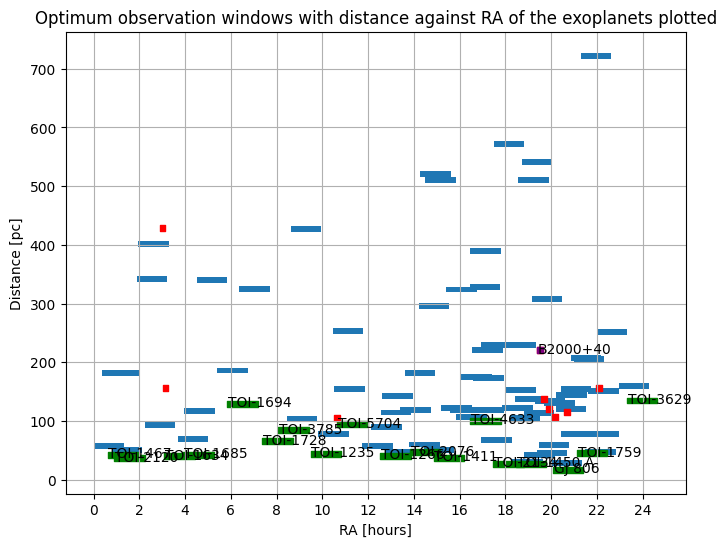

In [5]:
# Plot the optimum viewing windows for the targets
fig, ax = plt.subplots(figsize=(8,6))

# All planets
for i in range(len(data['ra'])):
    # Plot from optimum start time of observation to +20 degrees (1 hr 20 mins)
    ax.broken_barh([(data['ra'][i] - 10, 20)], (data['sy_dist'][i], 10))

# Targeted planets in a different colour
for i in range(len(target_list)):
    index = data['hostname'] == target_list[i]
    if sum(index) != 0:
        ind = np.argwhere(index)[0][0]

        # Plot from optimum start time of observation to +20 degrees (1 hr 20 mins)
        ax.broken_barh([(data['ra'][ind] - 10, 20)], (data['sy_dist'][ind], 10), color='green')
        ax.text(data['ra'][ind]+0.5 - 10, data['sy_dist'][ind], data['hostname'][ind])

# All pulsars
for i in range(len(bright_pulsars['start_obs'])):
    # Plot from optimum start time of observation to +3.75 degrees (15 mins)
    ax.broken_barh([(bright_pulsars['start_obs'][i], 3.75)], (bright_pulsars['R_LUM'][i]/10, 10), color='red')

# Targeted pulsar in a different colour
for i in range(len(bright_pulsars['start_obs'])):
    index = bright_pulsars['NAME'] == target_list[i]
    if sum(index) != 0:
        ind = np.argwhere(index)[0][0]

        # Plot from optimum start time of observation to +3.75 degrees (15 mins)
        ax.broken_barh([(bright_pulsars['start_obs'][ind], 3.75)], (bright_pulsars['R_LUM'][ind]/10, 10), color='purple')
        ax.text(bright_pulsars['start_obs'][ind]+0.5, bright_pulsars['R_LUM'][ind]/10, bright_pulsars['NAME'][ind])

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.grid(True)
ax.set_xlabel('RA [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('Optimum observation windows with distance against RA of the exoplanets plotted')

plt.show()

In [6]:
# Output schedule with pointings and timings
sched = Table(names=('target', 'ra', 'dec'), dtype=(str, float, float))

time = observing_time_start_mid.mjd

start_times = np.array([])
end_times = np.array([])

for i in range(len(target_list)):
    if target_type[i] == 'planet':
        index = data['hostname'] == target_list[i]
        ind = np.argwhere(index)[0][0]

        # Store times
        start_times = np.append(start_times, time)

        # Wait the 1 hr 21 minutes
        time += pointing_time_planet/24

        # If after waiting gone beyond the designated end time add the final end time, otherwise just add the end time for this observation
        if time >= observing_time_end_mid.mjd:
            end_times = np.append(end_times, observing_time_end_mid.mjd)
        else:
            end_times = np.append(end_times, time - (1*u.min).to(u.day).value)

        sched.add_row((data['hostname'][ind], data['ra'][ind]*np.pi/180, data['dec'][ind]*np.pi/180))
        
    elif target_type[i] =='psr':
        index = bright_pulsars['NAME'] == target_list[i]
        ind = np.argwhere(index)[0][0]

        # Store times
        start_times = np.append(start_times, time)
        # Wait the 16 minutes
        time += pointing_time_psr/24
        
        # If after waiting gone beyond the designated end time add the final end time, otherwise just add the end time for this observation
        if time >= observing_time_end_mid.mjd:
            end_times = np.append(end_times, observing_time_end_mid.mjd)
        else:
            end_times = np.append(end_times, time - (1*u.min).to(u.day).value)
        
        sched.add_row((bright_pulsars['NAME'][ind], bright_pulsars['RAJ'][ind]*np.pi/180, bright_pulsars['DECJ'][ind]*np.pi/180))

sched['target_type'] = target_type


# Add timings separately
sched['start_utc'] = Time(start_times, format='mjd').iso
sched['end_utc'] = Time(end_times, format='mjd').iso


# Remove any that start after the end time
rmv_rows = np.array([], dtype=int)
for i in range(len(sched['start_utc'])):
    if Time(sched['start_utc'][i], format='iso').mjd > Time(end_time, format='iso').mjd:
        rmv_rows = np.append(rmv_rows, int(i))

sched.remove_rows(rmv_rows)

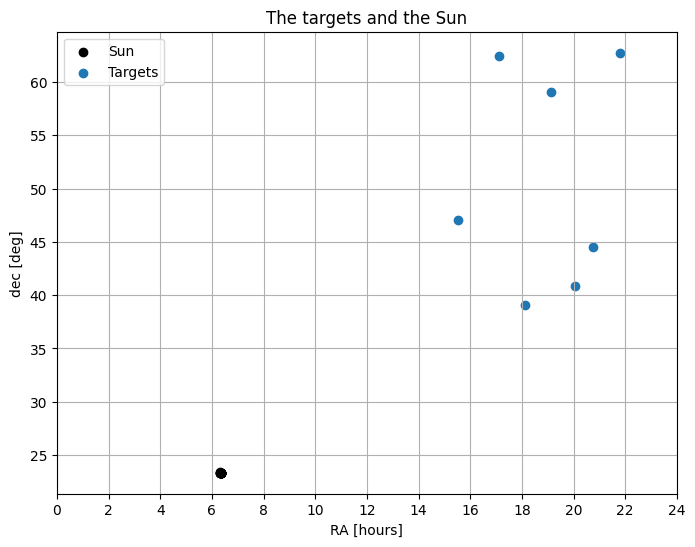

In [7]:
# Check if the targets approach the sun

# Time in the middle of observation
middle_times = (start_times + end_times)/2
sun_times = Time(middle_times, format='mjd')

# Sun's location at these times
sun_loc = coord.get_sun(sun_times)
sun_ra = sun_loc.ra
sun_dec = sun_loc.dec

# Plot targets and the sun
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(sun_ra, sun_dec, color='black', label='Sun')
ax.scatter(sched['ra']*180/np.pi, sched['dec']*180/np.pi, label='Targets')
ax.set_title('The targets and the Sun')
ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.grid(True)
ax.set_xlabel('RA [hours]')
ax.set_ylabel('dec [deg]')
ax.legend()

# Store angular distance to the sun in the output as well
dist_to_sun = np.array([])

for i in range(len(sched['ra'])):
    dist_to_sun = np.append(dist_to_sun, np.sqrt((sun_ra[i].value - sched['ra'][i]*180/np.pi)**2 + (sun_dec[i].value - sched['dec'][i]*180/np.pi)**2))
    if dist_to_sun[-1] <= 20 or dist_to_sun[-1] >= 340:
        print(f'Warning, %s is within 20 degrees of the Sun' %sched['target'][i])

In [8]:
# Output the schedule
ascii.write(sched, 'sched_out.csv', overwrite=True, delimiter=',')

Stuff below here is more for interest than anything else

Text(0.5, 1.0, 'Optimal target view time, RA against Distance of stars')

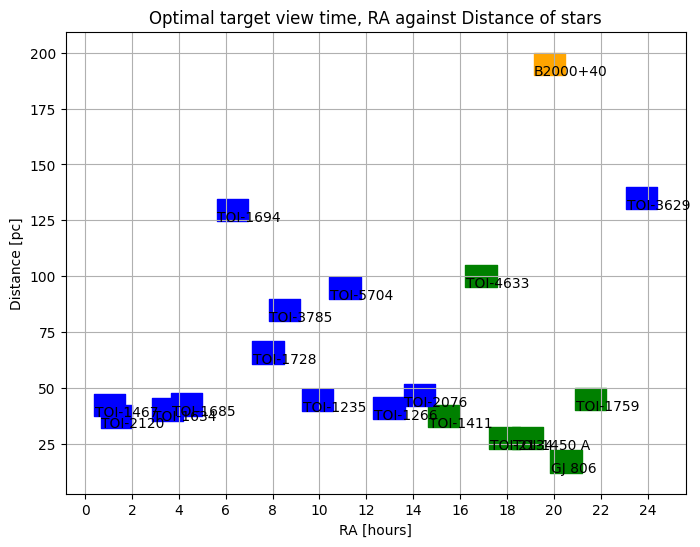

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)

pulsar_obs = False  
pulsar_offset = 0

width = pointing_time_planet * 20 / 2
for i in range(len(target_list)):
    if target_type[i] == 'planet':
        index = data['hostname'] == target_list[i]
        ind = np.argwhere(index)[0][0]

        # Plot from start time of observation to +20 degrees (1 hr 20 mins)
        # Check if passed into a new day, plot different colour if so
        if i < newday_cutoff:
            ax.broken_barh([(data['ra'][ind] - width, 20)], (data['sy_dist'][ind], 10), color='green')
        else: 
            ax.broken_barh([(data['ra'][ind] - width, 20)], (data['sy_dist'][ind], 10), color='blue')
        ax.text(data['ra'][ind]+0.5 - width, data['sy_dist'][ind], data['hostname'][ind])

    elif target_type[i] == 'psr':
        index = bright_pulsars['NAME'] == target_list[i]
        ind = np.argwhere(index)[0][0]

        ax.broken_barh([(bright_pulsars['RAJ'][ind] - width, 20)], (190, 10), color='orange')
        ax.text(bright_pulsars['RAJ'][ind] - width, 190, bright_pulsars['NAME'][ind])
        
ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.set_xlabel('RA [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('Optimal target view time, RA against Distance of stars')

Text(0.5, 1.0, 'Scheduled time, RA against Distance of stars, red dots - when the star reaches its zenith')

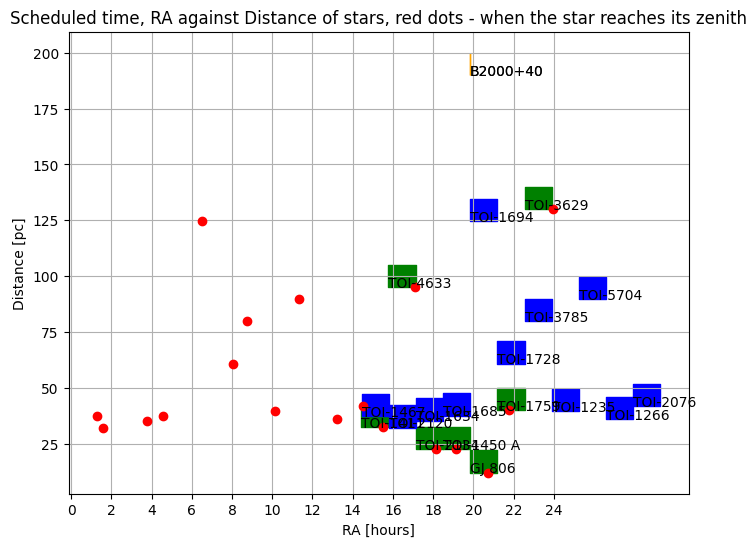

In [10]:
# Plot Actual viewing times
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True)

start_deg = LST_start_mid.value * 360/24

# Initially don't take into account the pulsar observation
pulsar_offset = 0

pulsar_obs = False

for i in range(len(target_list)):
    # Plot from start time of observation to +20 degrees (1 hr 20 mins)
    index = data['hostname'] == target_list[i]
    if target_type[i] == 'planet':
        ind = np.argwhere(index)[0][0]
        if pulsar_obs == True:
            pulsar_offset = pointing_time_psr
            i=i-1

        # Plot from start time of observation to +20 degrees (1 hr 20 mins)
        if i < newday_cutoff:
            # Plot at [len of planet observation * no planets already observed in hours + the initial offset as not starting from 0 + 1 minute for each wait + the offest due to the pulsar observation if necessary]
            ax.broken_barh([(pointing_time_planet * i * 15 + start_deg + pulsar_offset, pointing_time_planet * 15)], (data['sy_dist'][ind], 10), color='green')
            ax.text(pointing_time_planet * i * 15 + start_deg + pulsar_offset, data['sy_dist'][ind], data['hostname'][ind])
            ax.plot(data['ra'][ind], data['sy_dist'][ind], 'ro')

        else: 
            # Plot at [len of planet observation * no planets already observed in hours this day + the initial offset as not starting from 0 + 1 minute for each wait + the offest due to the pulsar observation if necessary]
            ax.broken_barh([(pointing_time_planet * (i - newday_cutoff) * 15 + start_deg + pulsar_offset, pointing_time_planet * 15)], (data['sy_dist'][ind], 10), color='blue')
            ax.text((pointing_time_planet * (i - newday_cutoff) * 15 + start_deg + pulsar_offset), data['sy_dist'][ind], data['hostname'][ind])
            ax.plot(data['ra'][ind], data['sy_dist'][ind], 'ro')

    if target_type[i]=='psr':
        pulsar_obs=True
        index = bright_pulsars['NAME'] == target_list[i]
        ind = np.argwhere(index)[0][0]

        ax.broken_barh([(pointing_time_planet * i * 15 + start_deg, pointing_time_psr)], (190, 10), color='orange')
        ax.text(pointing_time_planet * i * 15 + start_deg, 190, bright_pulsars['NAME'][ind])
        

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.set_xlabel('RA [hours]')
ax.set_ylabel('Distance [pc]')
ax.set_title('Scheduled time, RA against Distance of stars, red dots - when the star reaches its zenith')

In [11]:
sched

target,ra,dec,target_type,start_utc,end_utc
str10,float64,float64,str6,str23,str23
TOI-1411,4.065675499655459,0.8212742910541225,planet,2024-06-25 20:00:00.000,2024-06-25 21:20:00.000
TOI-4633,4.482757792680962,1.0904040145877583,planet,2024-06-25 21:21:00.000,2024-06-25 22:41:00.000
TOI-2134,4.746169854236978,0.6819512227960611,planet,2024-06-25 22:42:00.000,2024-06-26 00:02:00.000
TOI-1450 A,5.006547866837255,1.0312561571225116,planet,2024-06-26 00:03:00.000,2024-06-26 01:23:00.000
B2000+40,5.247914172538282,0.712937425805136,psr,2024-06-26 01:24:00.000,2024-06-26 01:39:00.000
GJ 806,5.432681130185652,0.7766756204065481,planet,2024-06-26 01:40:00.000,2024-06-26 03:00:00.000
TOI-1759,5.704637658788988,1.0952607143720148,planet,2024-06-26 03:01:00.000,2024-06-26 04:00:00.000


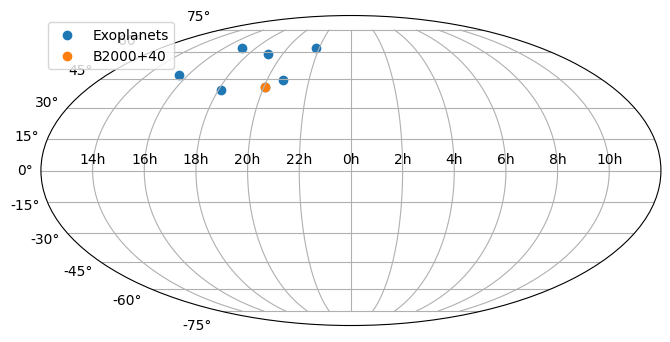

In [13]:
coords = coord.SkyCoord(ra=sched['ra']*u.rad, dec=sched['dec']*u.rad)

for i in range(len(sched['target_type'])):
    if sched['target_type'][i] == 'psr':
        coords_psr = coord.SkyCoord(ra=sched['ra'][i]*u.rad, dec=sched['dec'][i]*u.rad)
        name_psr = sched['target'][i]

ra = coords.ra
ra = ra.wrap_at(180*u.degree)
dec = coords.dec

ra_psr = coords_psr.ra
ra_psr = ra_psr.wrap_at(180*u.degree)
dec_psr = coords_psr.dec

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian, label='Exoplanets')
ax.scatter(ra_psr.radian, dec_psr.radian, label=name_psr)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend(loc=2)